In [115]:
# 데이터 처리, 모델 구축, 시각화를 위한 주요 라이브러리 및 모듈을 불러옵니다.
import gc  # Python의 가비지 컬렉터 관련 모듈로, 메모리 관리를 위해 객체 삭제를 명시적으로 제어할 수 있습니다.
import itertools  # 반복 가능한 객체로부터 조합, 순열 등 다양한 반복자를 생성하는 유틸리티 모듈입니다.
import matplotlib.pyplot as plt  # 정적/애니메이션/인터랙티브 시각화를 지원하는 matplotlib의 핵심 시각화 도구입니다.
import numpy as np  # 다차원 배열과 행렬 연산, 다양한 수학 함수 제공을 위한 수치 계산 라이브러리입니다.
import pandas as pd  # 데이터 프레임과 시리즈 객체를 기반으로 한 데이터 분석용 라이브러리입니다.
import seaborn as sns  # matplotlib을 기반으로 한 고급 통계 시각화 라이브러리입니다.
import os  # 운영체제와 상호작용하기 위한 모듈로, 파일 경로 탐색 등 OS 의존 기능을 지원합니다.
import xgboost  # 머신러닝용 XGBoost 라이브러리 (주로 회귀, 분류, 랭킹에 사용).
import warnings  # 경고 메시지 필터링 및 제어를 위한 모듈입니다.
import lightgbm as lgbm  # LightGBM: 그래디언트 부스팅 기반 머신러닝 프레임워크입니다.
import lightgbm as lgb  # LightGBM을 다른 별칭으로 중복 임포트 (보통은 하나만 임포트해도 충분합니다).
import ctypes  # C 언어 호환 데이터 타입을 사용하거나 외부 DLL/공유 라이브러리 호출 시 사용되는 모듈입니다.
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델을 구현하는 클래스입니다.

warnings.filterwarnings("ignore")  # 경고 메시지를 무시하여 출력 결과가 지저분하지 않도록 설정합니다.

In [116]:
# 쥬피터 노트북용 데이터 불러오기
df_train = pd.read_csv('./sales_train.csv')
df_categories = pd.read_csv("./item_categories.csv")
df_items = pd.read_csv("./items-translated.csv", encoding='cp1252') # 번역 후 파일을 input 폴더에 올려두었습니다. 파일명: items_translated
df_shops = pd.read_csv("./shops_graded.csv", encoding='cp1252') # ML코드에서는 shop_grade 컬럼을 사용하지 않아 버전2 업데이트 하지 않았습니다.
df_test = pd.read_csv("./test.csv")
calendar = pd.read_csv("./calendar.csv")

In [117]:
# 데이터 병합
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')
calendar['date'] = pd.to_datetime(calendar['date'])

df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')
df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')
df_train = pd.merge(df_train, calendar, on='date', how='left')

In [118]:
# category, shop 중분류 추가 (12초 소요)
df_train['city'] = df_train['shop_name'].str.split(' ').str[0]
df_train['sub_category'] = df_train['item_category_name'].str.split(' ').str[0]
# 중분류명 정리 → 13개
df_train['sub_category'] = df_train['sub_category'].replace({'Pure' : 'Carrier', 'Clean' : 'Carrier', 'Elements': 'Batteries', 'Payment' : 'Gift Card', 'Service' : 'Tickets', 'Android' : 'Games', 'Mac' : 'Games', 'Game' : 'Games'})
# city명 정리
df_train['city'] = df_train['city'].replace({'!' : 'Yakutsk', 'Exit' : 'Other', 'N.' : 'NizhnyNovgorod', 'SPb' : 'SanktPetersburg', 'Digital' : 'Online'})
# 원화 추가
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day'] # 판매 금액
df_train['krw_amount'] = df_train['total_amount'] * 18 # 국내 보고용 원화 표시, krw_amount로 표시
df_train = df_train.rename({'total_amount':'rub_amount'}, axis = 1)  # 기존 판매금액은 rub_amount로 표시

In [119]:
# dat 관련 컬럼 추가 # 보고용이므로 예측에는 불필요 시 사용하지 않아도 됩니다. (7초 소요)
# df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') (merge 직전에 완료)
df_train['year'] =  pd.to_datetime(df_train['date']).apply(lambda x : x.year)
df_train['month'] = pd.to_datetime(df_train['date']).apply(lambda x : x.month)
df_train['day'] = pd.to_datetime(df_train['date']).apply(lambda x : x.day)
df_train['year_month'] = df_train['date'].dt.to_period('M')

In [120]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,shop_grade,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
76962,2013-01-05,0,54,20130,149.0,1.0,SCIENTIFIC CHARODEA (region),40,Cinema - DVD,"Khimki shopping center ""mega""",A,0,1,Khimki,Cinema,149.0,2682.0,2013,1,5,2013-01
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",C,1,1,Tyumen,Games,999.0,17982.0,2014,2,23,2014-02
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow MTRC ""Afers Mall""",A,0,1,Moscow,Games,999.0,17982.0,2014,3,23,2014-03
1671873,2014-05-01,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",C,1,0,Tyumen,Games,999.0,17982.0,2014,5,1,2014-05
1866340,2014-07-12,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow TRK ""Atrium""",A,0,1,Moscow,Games,999.0,17982.0,2014,7,12,2014-07
2198566,2014-12-31,23,42,21619,499.0,1.0,THE MAN OF RAIN (BD),37,Cinema - Blu -Ray,"SPb TK ""Nevsky Center""",A,0,0,SanktPetersburg,Cinema,499.0,8982.0,2014,12,31,2014-12


In [121]:
# 중복 제거 # 6개 건
df_train.drop_duplicates(inplace=True)

In [122]:
# df_train

In [123]:
test = pd.read_csv('./test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [124]:
data = df_train.copy()

In [125]:
# data

In [126]:
data = data.drop(['shop_name', 'item_name_translated', 'item_category_name'], axis=1)
# 해당 컬럼들은 각 id컬럼과 1대1 매칭이므로 둘 중 하나는 제거

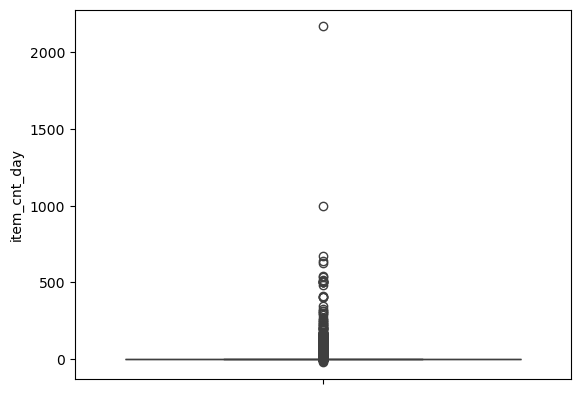

In [127]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y='item_cnt_day', data=data);
plt.show()

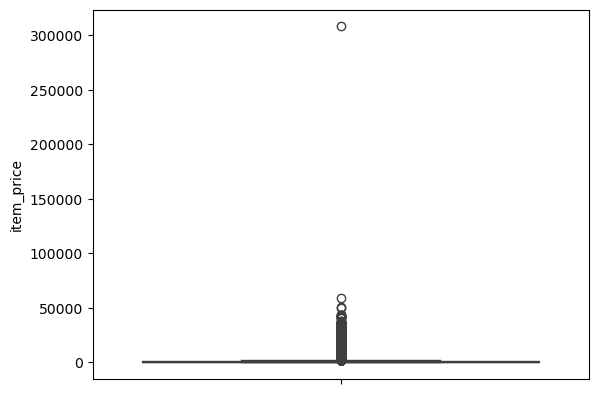

In [128]:
sns.boxplot(y='item_price', data=data);
plt.show()

### 이상치 제거

In [129]:
# 이상치 조건에 해당하는 행들 인덱스 추출
outlier_condition = (data['item_cnt_day'] >= 1000) | (data['item_price'] >= 100000)

# 이상치가 아닌 데이터만 필터링
data_cleaned = data[~outlier_condition].copy()
print(data_cleaned.shape)

(2935840, 18)


In [130]:
data_cleaned.isna().sum() # 결측치 없음

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
shop_grade          0
holiday             0
weekend             0
city                0
sub_category        0
rub_amount          0
krw_amount          0
year                0
month               0
day                 0
year_month          0
dtype: int64

In [131]:
# 그룹화하여 월별 월간 판매량
group = data_cleaned.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index() # 인덱스 재설정

,date_block_num,item_cnt_day
0,0,131478.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


In [132]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성 
for i in data_cleaned['date_block_num'].unique():
    all_shop = data_cleaned.loc[data_cleaned['date_block_num']==i, 'shop_id'].unique()
    all_item = data_cleaned.loc[data_cleaned['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # 기준 피처
# 리스트 타입인 train을 DataFrame 타입으로 변환 
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913799,33,21,7635
10913800,33,21,7638
10913801,33,21,7640
10913802,33,21,7632


### Feature Engineering 타깃값 추가 (월간 판매량)

In [133]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기 
group = data_cleaned.groupby(idx_features).agg({'item_cnt_day': 'sum'})
# 인덱스 재설정
group = group.reset_index()
# '판매량'에서 '월간 판매량'
group = group.rename(columns={'item_cnt_day': 'item_cnt_monthly'})

group

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609117,33,59,22087,6.0
1609118,33,59,22088,2.0
1609119,33,59,22091,1.0
1609120,33,59,22100,1.0


In [134]:
# train과 group 병합
train = train.merge(group, on=idx_features, how='left')
train

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913799,33,21,7635,NaN
10913800,33,21,7638,NaN
10913801,33,21,7640,NaN
10913802,33,21,7632,NaN


In [135]:
import gc # 가비지 컬렉터

del group # 더는 사용하지 않는 변수 지정
gc.collect(); # 가비지 컬렉션 수행

### Feature Engineering test data 이어붙이기
train data의 월ID는 0~33으로 마지막이 2015년 10월인데, test data는 2015년 11월이므로 월ID feature를 34로 설정한다.  
test data에서 식별자 역할을 하는 ID를 제외하고 test data를 train data와 merge

In [136]:
test['date_block_num'] = 34  # 2015년 11월 예측 대상

all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True, 
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

# 결측값 0으로 채우기
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0


### Feature Engineering 나머지 데이터 병합 (최종 데이터 생성)

In [137]:
# all_data

In [138]:
import numpy as np
import pandas as pd

def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        dtype = df[col].dtype

        if pd.api.types.is_object_dtype(dtype):
            # object는 건너뜀
            continue
        elif pd.api.types.is_bool_dtype(dtype):
            df[col] = df[col].astype('int8')
        elif pd.api.types.is_integer_dtype(dtype):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(dtype):
            # 소수점이 없는 float는 int로 변환
            col_non_na = df[col].dropna()
            if (col_non_na == col_non_na.astype(int)).all():
                df[col] = pd.to_numeric(df[col], downcast='integer')
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            # 예: datetime, category 등은 건너뜀
            continue

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [139]:
all_df = [df_train, df_shops, df_items, df_categories, test]
for df in all_df:
    df = downcast(df)

38.1% 압축됨
26.7% 압축됨
54.2% 압축됨
39.8% 압축됨
75.0% 압축됨


In [140]:
all_data = all_data.merge(df_shops, on='shop_id', how='left')
all_data = all_data.merge(df_items, on='item_id', how='left')
all_data = all_data.merge(df_categories, on='item_category_id', how='left')
all_data = all_data.drop(['shop_name', 'item_name_translated', 'item_category_name'], axis=1)
# 데이터 다운캐스팅
all_data = downcast(all_data)

# # 가비지 컬렉션
# del df_shops, df_items, df_categories
# # del df_shops, df_categories # df_items -> 아래에서 사용하므로 버리지 않음
# gc.collect();

63.4% 압축됨


In [141]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_monthly'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_monthly'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_monthly'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_monthly']
y_train = y_train.clip(0, 20) # 타깃값을 0 ~ 20로 제한
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_monthly']
y_valid = y_valid.clip(0, 20)

학습 데이터 X_train, y_train : 33월 이전 데이터로 학습  
검증 데이터 X_valid, y_valid : 33월 데이터로 모델 검증  
테스트 데이터 X_test: 34월 데이터로 예측  

In [142]:
X_train.shape

(10675632, 5)

In [143]:
y_train.shape

(10675632,)

In [144]:
X_valid.shape

(238172, 5)

In [145]:
y_valid.shape

(238172,)

In [146]:
X_train = X_train.drop('shop_grade', axis=1)
X_valid = X_valid.drop('shop_grade', axis=1)
X_test = X_test.drop('shop_grade', axis=1)

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)
y_pred_valid = np.clip(y_pred_valid, 0, 20)
mse = mean_squared_error(y_valid, y_pred_valid)
rmse = np.sqrt(mse)
print(f"검증 RMSE: {rmse:.4f}")
# y_pred_test = model.predict(X_test)

검증 RMSE: 1.1368


In [148]:
y_pred_test = model.predict(X_test)

y_pred_test = model.predict(X_test)
y_pred_test = np.clip(y_pred_test, 0, 20)

print(y_pred_test)

[0.44613277 0.20819708 0.44453035 ... 0.19413805 0.26050265 0.4328497 ]


## 성능 개선 개별 데이터 피처 엔지니어링

### 이상치 제거 및 전처리

In [149]:
df_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,shop_grade,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.0,1,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",C,1,0,Yaroslavl,Cinema,999.0,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.0,1,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,1,0,Moscow,Music,899.0,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.0,-1,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,0,1,Moscow,Music,-899.0,-16182.0,2013,1,5,2013-01


In [150]:
# 판매가가 0보다 큰 데이터 추출
df_train = df_train[df_train['item_price'] > 0]
# 판매가가 50,000보다 작은 데이터 추출
df_train = df_train[df_train['item_price'] < 50000]

# 판매량이 0보다 큰 데이터 추출
df_train = df_train[df_train['item_cnt_day'] > 0]
# 판매량이 1,000보다 작은 데이터 추출
df_train = df_train[df_train['item_cnt_day'] < 1000]

상점명을 조금 다르게 기입해서 같은 상점인데 다르게 기록되어 있는 상점이 4쌍 있기에 각 쌍의 상점ID를 수정해준다. 상점명은 어차피 제거할 것이기에 수정하지 않아도 된다. -> 수정하지않음

### 도시명은 범주형 피처이므로 레이블 인코딩

In [151]:
# df_train에서 shop_id와 city 정보만 추출 후 중복 제거
shop_city_map = df_train[['shop_id', 'city']].drop_duplicates()

# df_shops가 안 불러와지니까 shop_id만 따로 생성한 뒤 병합
shops = pd.DataFrame({'shop_id': df_train['shop_id'].unique()})
shops = shops.merge(shop_city_map, on='shop_id', how='left')

In [152]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
shops['city'] = label_encoder.fit_transform(shops['city'])

In [153]:
# # item_id별 첫 판매 월 추출
# first_sales_month = df_train.groupby('item_id', as_index=False)['date_block_num'].min()
# first_sales_month.rename(columns={'date_block_num': 'first_sales_month'}, inplace=True)

# # 새로운 DataFrame 생성
# items = first_sales_month.copy()

In [154]:
# item_id별 첫 판매 월 추출
first_sales_month = df_train.groupby('item_id', as_index=False)['date_block_num'].min()
first_sales_month.rename(columns={'date_block_num': 'first_sales_month'}, inplace=True)

# item_id별 item_category_id 추출 (중복 제거)
item_categories = df_train[['item_id', 'item_category_id']].drop_duplicates()

# first_sales_month와 item_category_id 합치기
items = first_sales_month.merge(item_categories, on='item_id', how='left')

In [155]:
items.head(3)

,item_id,first_sales_month,item_category_id
0,0,20,40
1,1,15,76
2,2,19,40


In [156]:
items['first_sales_month'].isna().sum()

0

In [157]:
# item_category_id와 sub_category 정보를 df_train에서 추출 후 중복 제거
item_categories = df_train[['item_category_id', 'sub_category']].drop_duplicates().reset_index(drop=True)

In [158]:
# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 대분류 피처 레이블 인코딩
item_categories['sub_category'] = label_encoder.fit_transform(item_categories['sub_category'])

In [159]:
# shops -> shop_id, city

In [160]:
# items -> item_id, first_sales_month, item_category_id

In [161]:
# item_categories -> item_category_id, sub_category

### 파생 변수 생성
- 월, 상점, 상품별 월간 판매량과 평균 판매가 변수를 만들고, 기준 feature별 상품 판매건수 feature를 만들어 준다.

In [162]:
# 충돌 방지를 위해 기존 컬럼 삭제
train = train.drop(columns=['item_cnt_monthly'], errors='ignore')

group = df_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_monthly', 'item_price': 'mean_item_price'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


### test data를 train에 합치기

In [163]:
# 테스트 데이터 월ID를 34로 설정
test['date_block_num'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


item_cnt_monthly컬럼이 하나가 되어야 함 -> ok  
판매건수가 붙어있지 않음 

In [164]:
# # 테스트 데이터 월ID를 34로 설정
# test['date_block_num'] = 34

# # train과 test 이어붙이기
# all_data = pd.concat([train, test.drop('ID', axis=1)],
#                      ignore_index=True,
#                      keys=idx_features)
# # 결측값을 0으로 대체
# all_data = all_data.fillna(0)

# all_data.head()

all_data에 item_category_id가 없어서 merge가 안 됨 -> merge 하여 해결 

In [165]:
print(items['item_id'].duplicated().sum())

0


In [166]:
all_data.isna().sum()

date_block_num      0
shop_id             0
item_id             0
item_cnt_monthly    0
mean_item_price     0
dtype: int64

In [167]:
all_data['item_id'].nunique()

22169

In [168]:
items['item_id'].nunique()

21802

In [169]:
items

,item_id,first_sales_month,item_category_id
0,0,20,40
1,1,15,76
2,2,19,40
3,3,18,40
4,4,20,40
...,...,...,...
21797,22165,7,31
21798,22166,9,54
21799,22167,8,49
21800,22168,0,62


In [170]:
all_data = all_data.merge(items, on='item_id', how='left')

In [171]:
print(all_data[['item_id', 'first_sales_month']].isna().sum())

item_id                  0
first_sales_month    15430
dtype: int64


In [172]:
all_data = all_data[all_data['first_sales_month'].notna()].reset_index(drop=True) # 결측치는 drop or fillna(0) 중에 제거 선택

In [173]:
print(all_data[['item_id', 'first_sales_month']].isna().sum())

item_id              0
first_sales_month    0
dtype: int64


In [174]:
# all_data

In [175]:
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

In [176]:
merge_df = all_data.copy() # 혹시 몰라서 copy

In [177]:
all_data = downcast(all_data)

71.9% 압축됨


In [178]:
del shops, items, item_categories
# del shops, item_categories
gc.collect();

In [179]:
all_data

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price,first_sales_month,item_category_id,city,sub_category
0,0,59,22154,1,999.0,0,37,28,4
1,0,59,2552,0,0.0,0,58,28,9
2,0,59,2554,0,0.0,0,58,28,9
3,0,59,2555,0,0.0,0,56,28,9
4,0,59,2564,0,0.0,0,59,28,9
...,...,...,...,...,...,...,...,...,...
11112569,34,45,18454,0,0.0,23,55,17,9
11112570,34,45,16188,0,0.0,32,64,17,8
11112571,34,45,15757,0,0.0,0,55,17,9
11112572,34,45,19648,0,0.0,23,40,17,4


NameError: name 'shops' is not defined -> 해당 셀 실행을 2번함 -> 해결ok

### 시차(time lag) feature 생성
타깃값과 관련된 "기준 feauture별 월간 평균 판매량" feature를 만들고 이를 활용해 시차 feature를 만들도록한다.

In [180]:
def add_mean_features(df, mean_features, idx_features): # df->all_data
    # 기준 피처 확인 
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]

    # 파생 피처명 설정 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'

    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기 
    group = df.groupby(idx_features).agg({'item_cnt_monthly': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_monthly': feature_name})

    # df와 group 병합 
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅 
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가 
    mean_features.append(feature_name)

    # 가비지 컬렉션
    del group
    gc.collect()

    return df, mean_features

In [181]:
# # 테스트 데이터 월ID를 34로 설정
# test['date_block_num'] = 34

# # train과 test 이어붙이기
# all_data = pd.concat([train, test.drop('ID', axis=1)],
#                      ignore_index=True,
#                      keys=idx_features)
# # 결측값을 0으로 대체
# all_data = all_data.fillna(0)

# all_data.head()

여기서 이 셀을 지나면 all_data가 reset되는 문제 -> 일단 지나게 해서 추후에 merge하는 방법

In [182]:
test['date_block_num'] = 34
all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True)
all_data = all_data.fillna(0)
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


In [183]:
# # test에 train의 컬럼 구조를 맞춰줌 -> test에 없는 컬럼이 fillna 되지 않게 함
# for col in train.columns:
#     if col not in test.columns and col != 'ID':
#         test[col] = np.nan

# test['date_block_num'] = 34

# # 합치기
# all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True)
# all_data = all_data.fillna(0)

In [184]:
# all_data와 df_train에 모두 존재하는 'shop_id'컬럼을 기준으로 병합
# df_train에서 중복 제거 후 city 컬럼만 추출
shop_city = df_train[['shop_id', 'city']].drop_duplicates()

# all_data에 병합 (중복 컬럼 방지)
all_data = all_data.merge(shop_city, on='shop_id', how='left')

all_data에 city컬럼을 merge 하였으므로 아래 행이 실행되어야 함 -> ok

In [185]:
# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

item_mean_features

['item_id별 평균 판매량', 'item_id city별 평균 판매량']

In [186]:
# item_id 기준으로 item_category_id 병합
item_category = df_train[['item_id', 'item_category_id']].drop_duplicates()
all_data = all_data.merge(item_category, on='item_id', how='left')

In [187]:
# 그룹화 기준 피처 중 '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

shop_mean_features

['shop_id item_category_id별 평균 판매량']

In [188]:
# def add_lag_features(df, lag_features_to_clip, idx_features, 
#                      lag_feature, nlags=3, clip=False):
#     # 시차 피처 생성에 필요한 DataFrame 부분만 복사 
#     df_temp = df[idx_features + [lag_feature]].copy() 

#     # 시차 피처 생성 
#     for i in range(1, nlags+1):
#         # 시차 피처명 
#         lag_feature_name = lag_feature +'_시차' + str(i)
#         # df_temp 열 이름 설정 
#         df_temp.columns = idx_features + [lag_feature_name]
#         # df_temp의 date_block_num 피처에 1 더하기 
#         df_temp['date_block_num'] += 1
#         # idx_feature를 기준으로 df와 df_temp 병합하기 
#         df = df.merge(df_temp.drop_duplicates(), 
#                       on=idx_features, 
#                       how='left')
#         # 결측값 0으로 대체 
#         df[lag_feature_name] = df[lag_feature_name].fillna(0)
#         # 0 ~ 20 사이로 제한할 시차 피처명을 lag_features_to_clip에 추가 
#         if clip: 
#             lag_features_to_clip.append(lag_feature_name)

#     # 데이터 다운캐스팅
#     df = downcast(df, False)
#     # 가비지 컬렉션
#     del df_temp
#     gc.collect()

#     return df, lag_features_to_clip

In [189]:
# def add_lag_features(df, lag_features_to_clip, idx_features, 
#                      lag_feature, nlags=3, clip=False):
#     df_temp = df[idx_features + [lag_feature]].copy()

#     for i in range(1, nlags + 1):
#         lag_feature_name = lag_feature + '_시차' + str(i)
        
#         # 복사 후 컬럼명 변경은 루프 안에서 이뤄져야 하되, 컬럼 수가 정확해야 함
#         df_shift = df_temp.copy()
#         df_shift['date_block_num'] += i
#         df_shift.rename(columns={lag_feature: lag_feature_name}, inplace=True)

#         df = df.merge(df_shift, on=idx_features, how='left')
#         df[lag_feature_name] = df[lag_feature_name].fillna(0)

#         if clip:
#             lag_features_to_clip.append(lag_feature_name)

#     df = downcast(df, False)
#     gc.collect()
#     return df, lag_features_to_clip


In [190]:
# def add_lag_features(df, lag_features_to_clip, idx_features, 
#                      lag_feature, nlags=3, clip=False):
#     df_temp = df[idx_features + [lag_feature]].copy()

#     for i in range(1, nlags + 1):
#         lag_feature_name = f'{lag_feature}_시차{i}'

#         df_shift = df_temp.copy()
#         df_shift['date_block_num'] += i
#         df_shift.rename(columns={lag_feature: lag_feature_name}, inplace=True)

#         # 병합
#         df = df.merge(df_shift, on=idx_features, how='left')

#         # fillna 안전하게 적용
#         if lag_feature_name in df.columns:
#             df.loc[:, lag_feature_name] = df[lag_feature_name].fillna(0)
#         else:
#             print(f"[경고] 병합 후 {lag_feature_name} 컬럼이 존재하지 않습니다.")

#         # 클리핑 대상 피처 추가
#         if clip:
#             lag_features_to_clip.append(lag_feature_name)

#     df = downcast(df, False)
#     gc.collect()
#     return df, lag_features_to_clip
# 그래도 실행은 됨

In [191]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    df_temp = df[idx_features + [lag_feature]].copy()

    for i in range(1, nlags + 1):
        lag_feature_name = lag_feature + '_시차' + str(i)

        # 중복 컬럼 있으면 제거
        if lag_feature_name in df.columns:
            df = df.drop(columns=[lag_feature_name])
            # df_temp, df 모두 컬럼이 존재하여 중복 문제로 하나는 거거

        df_temp.columns = idx_features + [lag_feature_name]
        df_temp['date_block_num'] += 1

        df = df.merge(df_temp.drop_duplicates(), on=idx_features, how='left')

        df[lag_feature_name] = df[lag_feature_name].fillna(0)

        if clip:
            lag_features_to_clip.append(lag_feature_name)

    df = downcast(df, False)
    del df_temp
    gc.collect()

    return df, lag_features_to_clip


In [192]:
lag_features_to_clip = [] # 0 ~ 20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['date_block_num', 'shop_id', 'item_id'] # 기준 피처

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_monthly', 
                                                  nlags=3,
                                                  clip=True) # 값을 0 ~ 20 사이로 제한

In [193]:
# idx_features를 기준으로 판매건수 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_monthly', 
                                                  nlags=3)

# idx_features를 기준으로 평균 판매가 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='mean_item_price', 
                                                  nlags=3)

In [194]:
# all_data

In [195]:
print(all_data.columns.tolist())

['date_block_num', 'shop_id', 'item_id', 'item_cnt_monthly', 'mean_item_price', 'city', 'item_id별 평균 판매량', 'item_id city별 평균 판매량', 'item_category_id', 'shop_id item_category_id별 평균 판매량', 'item_cnt_monthly_시차1', 'item_cnt_monthly_시차2', 'item_cnt_monthly_시차3', 'mean_item_price_시차1', 'mean_item_price_시차2', 'mean_item_price_시차3']


In [196]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

In [197]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

In [198]:
# 월ID 3미만인 데이터 제거
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

In [199]:
# all_data

### 기타 feature engineering

In [200]:
pd.set_option('display.max_columns', None)
all_data

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price,city,item_category_id,item_cnt_monthly_시차1,item_cnt_monthly_시차2,item_cnt_monthly_시차3,mean_item_price_시차1,mean_item_price_시차2,mean_item_price_시차3,item_id별 평균 판매량_시차1,item_id별 평균 판매량_시차2,item_id별 평균 판매량_시차3,item_id city별 평균 판매량_시차1,item_id city별 평균 판매량_시차2,item_id city별 평균 판매량_시차3,shop_id item_category_id별 평균 판매량_시차1,shop_id item_category_id별 평균 판매량_시차2,shop_id item_category_id별 평균 판매량_시차3
1122795,3,25,8092,3,149.0,Moscow,40.0,1,0,4,149.0,0.0,149.0,0.586957,0.630435,1.444444,0.666667,0.666667,2.000000,1.035039,0.899247,0.995823
1122796,3,25,7850,3,199.0,Moscow,30.0,5,1,6,199.0,199.0,199.0,1.869565,1.456522,3.088889,2.916667,2.083333,2.916667,3.554645,2.083532,2.163855
1122797,3,25,8051,3,30.0,Moscow,66.0,0,0,0,0.0,0.0,0.0,0.043478,0.130435,0.133333,0.000000,0.333333,0.333333,1.796610,2.175439,1.320000
1122798,3,25,8088,1,199.0,Moscow,55.0,1,1,0,199.0,199.0,0.0,0.130435,0.043478,0.066667,0.166667,0.083333,0.000000,0.569322,0.544919,0.534779
1122799,3,25,8089,1,199.0,Moscow,55.0,0,1,0,0.0,199.0,0.0,0.478261,0.260870,0.177778,0.666667,0.250000,0.083333,0.569322,0.544919,0.534779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0,0.0,Samara,55.0,1,0,0,99.0,0.0,0.0,0.045455,0.023256,0.071429,0.500000,0.000000,0.000000,0.126866,0.074534,0.106061
11128000,34,45,16188,0,0.0,Samara,64.0,0,0,0,0.0,0.0,0.0,0.022727,0.069767,0.000000,0.000000,0.000000,0.000000,0.094488,0.117117,0.000000
11128001,34,45,15757,0,0.0,Samara,55.0,0,0,0,0.0,0.0,0.0,0.113636,0.069767,0.095238,0.000000,0.500000,0.000000,0.126866,0.074534,0.106061
11128002,34,45,19648,0,0.0,Samara,40.0,0,0,0,0.0,0.0,0.0,0.045455,0.069767,0.166667,0.000000,0.000000,0.000000,0.083756,0.074074,0.111645


In [201]:
all_data['월간 판매량 시차평균'] = all_data[['item_cnt_monthly_시차1',
                                          'item_cnt_monthly_시차2', 
                                          'item_cnt_monthly_시차3']].mean(axis=1)

In [202]:
# 0 ~ 20 사이로 값 제한
all_data[lag_features_to_clip + ['item_cnt_monthly', '월간 판매량 시차평균']] = all_data[lag_features_to_clip + ['item_cnt_monthly', '월간 판매량 시차평균']].clip(0, 20)

월간판매량 -> item_cnt_monthly 로 바꿔야 할 것 같은데 오류 날까봐 일단 둠 -> 수정해서 오류 해결

In [203]:
all_data['시차변화량1'] = all_data['item_cnt_monthly_시차1']/all_data['item_cnt_monthly_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['item_cnt_monthly_시차2']/all_data['item_cnt_monthly_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [204]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005209 entries, 1122795 to 11128003
Data columns (total 25 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_monthly                      int16  
 4   mean_item_price                       float64
 5   city                                  object 
 6   item_category_id                      float64
 7   item_cnt_monthly_시차1                  int16  
 8   item_cnt_monthly_시차2                  int16  
 9   item_cnt_monthly_시차3                  int16  
 10  mean_item_price_시차1                   float64
 11  mean_item_price_시차2                   float64
 12  mean_item_price_시차3                   float64
 13  item_id별 평균 판매량_시차1                   float32
 14  item_id별 평균 판매량_시차2                   float32
 15  item_id

In [205]:
all_data.isna().sum()

date_block_num                              0
shop_id                                     0
item_id                                     0
item_cnt_monthly                            0
mean_item_price                             0
city                                        0
item_category_id                        15339
item_cnt_monthly_시차1                        0
item_cnt_monthly_시차2                        0
item_cnt_monthly_시차3                        0
mean_item_price_시차1                         0
mean_item_price_시차2                         0
mean_item_price_시차3                         0
item_id별 평균 판매량_시차1                         0
item_id별 평균 판매량_시차2                         0
item_id별 평균 판매량_시차3                         0
item_id city별 평균 판매량_시차1                    0
item_id city별 평균 판매량_시차2                    0
item_id city별 평균 판매량_시차3                    0
shop_id item_category_id별 평균 판매량_시차1        0
shop_id item_category_id별 평균 판매량_시차2        0
shop_id item_category_id별 평균 판매량_시

In [206]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11112574 entries, 0 to 11112573
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   date_block_num     int64  
 1   shop_id            int64  
 2   item_id            int64  
 3   item_cnt_monthly   float64
 4   mean_item_price    float64
 5   first_sales_month  float64
 6   item_category_id   float64
 7   city               int32  
 8   sub_category       int32  
dtypes: float64(4), int32(2), int64(3)
memory usage: 678.3 MB


In [207]:
merge_df_filtered = merge_df[['item_id', 'first_sales_month', 'sub_category']].drop_duplicates('item_id')

# NaN 허용되는 정수형으로 변환
merge_df_filtered['first_sales_month'] = merge_df_filtered['first_sales_month'].astype('Int8')
merge_df_filtered['sub_category'] = merge_df_filtered['sub_category'].astype('Int8')

# 기존 컬럼 제거 (있다면)
for col in ['first_sales_month', 'sub_category']:
    if col in all_data.columns:
        all_data = all_data.drop(columns=col)

# merge
all_data = all_data.merge(merge_df_filtered, on='item_id', how='left')

In [208]:
all_data['신상여부'] = all_data['first_sales_month'] == all_data['date_block_num']

In [209]:
all_data['월'] = all_data['date_block_num'] % 12

In [210]:
all_data.isna().sum()

date_block_num                              0
shop_id                                     0
item_id                                     0
item_cnt_monthly                            0
mean_item_price                             0
city                                        0
item_category_id                        15339
item_cnt_monthly_시차1                        0
item_cnt_monthly_시차2                        0
item_cnt_monthly_시차3                        0
mean_item_price_시차1                         0
mean_item_price_시차2                         0
mean_item_price_시차3                         0
item_id별 평균 판매량_시차1                         0
item_id별 평균 판매량_시차2                         0
item_id별 평균 판매량_시차3                         0
item_id city별 평균 판매량_시차1                    0
item_id city별 평균 판매량_시차2                    0
item_id city별 평균 판매량_시차3                    0
shop_id item_category_id별 평균 판매량_시차1        0
shop_id item_category_id별 평균 판매량_시차2        0
shop_id item_category_id별 평균 판매량_시

In [211]:
# # 첫 판매월, 평균 판매가, 판매건수 피처 제거
# all_data = all_data.drop(['first_sales_month', 'mean_item_price', 'item_cnt_monthly'], axis=1)

In [212]:
all_data.isna().sum()

date_block_num                              0
shop_id                                     0
item_id                                     0
item_cnt_monthly                            0
mean_item_price                             0
city                                        0
item_category_id                        15339
item_cnt_monthly_시차1                        0
item_cnt_monthly_시차2                        0
item_cnt_monthly_시차3                        0
mean_item_price_시차1                         0
mean_item_price_시차2                         0
mean_item_price_시차3                         0
item_id별 평균 판매량_시차1                         0
item_id별 평균 판매량_시차2                         0
item_id별 평균 판매량_시차3                         0
item_id city별 평균 판매량_시차1                    0
item_id city별 평균 판매량_시차2                    0
item_id city별 평균 판매량_시차3                    0
shop_id item_category_id별 평균 판매량_시차1        0
shop_id item_category_id별 평균 판매량_시차2        0
shop_id item_category_id별 평균 판매량_시

In [213]:
# 결측치가 생긴 컬럼 리스트
cols_with_na = ['item_category_id', 'sub_category', '신상여부']

# 결측치가 하나라도 있는 행 제거
all_data = all_data.dropna(subset=cols_with_na).reset_index(drop=True)

In [214]:
all_data.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
item_cnt_monthly                        0
mean_item_price                         0
city                                    0
item_category_id                        0
item_cnt_monthly_시차1                    0
item_cnt_monthly_시차2                    0
item_cnt_monthly_시차3                    0
mean_item_price_시차1                     0
mean_item_price_시차2                     0
mean_item_price_시차3                     0
item_id별 평균 판매량_시차1                     0
item_id별 평균 판매량_시차2                     0
item_id별 평균 판매량_시차3                     0
item_id city별 평균 판매량_시차1                0
item_id city별 평균 판매량_시차2                0
item_id city별 평균 판매량_시차3                0
shop_id item_category_id별 평균 판매량_시차1    0
shop_id item_category_id별 평균 판매량_시차2    0
shop_id item_category_id별 평균 판매량_시차3    0
월간 판매량 시차평균                             0
시차변화량1                            

In [215]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()
# 도시 피처 레이블 인코딩
all_data['city'] = label_encoder.fit_transform(all_data['city'])

In [216]:
all_data = downcast(all_data, False) # 데이터 다운캐스팅

In [217]:
# # 훈련 데이터 (피처)
# X_train = all_data[all_data['date_block_num'] < 33]
# # X_train = X_train.drop(['item_cnt_monthly'], axis=1)
# # 검증 데이터 (피처)
# X_valid = all_data[all_data['date_block_num'] == 33]
# # X_valid = X_valid.drop(['item_cnt_monthly'], axis=1)
# # 테스트 데이터 (피처)
# X_test = all_data[all_data['date_block_num'] == 34]
# # X_test = X_test.drop(['item_cnt_monthly'], axis=1)

# # 훈련 데이터 (타깃값)
# y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_monthly']
# # 검증 데이터 (타깃값)
# y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_monthly']

# # 가비지 컬렉션
# del all_data
# gc.collect();

In [218]:
# 타깃값 (item_cnt_monthly) 먼저 분리
y_train = all_data.loc[all_data['date_block_num'] < 33, 'item_cnt_monthly']
y_valid = all_data.loc[all_data['date_block_num'] == 33, 'item_cnt_monthly']

# 예측에 필요 없는 피처 제거 (타깃과 누설 가능성 있는 것들)
all_data = all_data.drop(['first_sales_month', 'mean_item_price', 'item_cnt_monthly'], axis=1)

# 학습/검증/테스트용 피처 데이터 분리
X_train = all_data[all_data['date_block_num'] < 33]
X_valid = all_data[all_data['date_block_num'] == 33]
X_test = all_data[all_data['date_block_num'] == 34]

# 메모리 정리
del all_data
gc.collect()


0

In [219]:
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

y_train shape: (9552744,)
y_valid shape: (238172,)
X_train shape: (9552744, 26)
X_valid shape: (238172, 26)
X_test shape: (198954, 26)


In [220]:
print("y_train stats:")
print(y_train.describe())

print("y_valid stats:")
print(y_valid.describe())

y_train stats:
count    9.552744e+06
mean     2.946082e-01
std      1.212860e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: item_cnt_monthly, dtype: float64
y_valid stats:
count    238172.000000
mean          0.259056
std           1.137015
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_monthly, dtype: float64


In [221]:
print(X_train.columns)
print(X_valid.columns)
# 여기에 파생 변수가 있으면 모델에도 들어감

Index(['date_block_num', 'shop_id', 'item_id', 'city', 'item_category_id',
       'item_cnt_monthly_시차1', 'item_cnt_monthly_시차2', 'item_cnt_monthly_시차3',
       'mean_item_price_시차1', 'mean_item_price_시차2', 'mean_item_price_시차3',
       'item_id별 평균 판매량_시차1', 'item_id별 평균 판매량_시차2', 'item_id별 평균 판매량_시차3',
       'item_id city별 평균 판매량_시차1', 'item_id city별 평균 판매량_시차2',
       'item_id city별 평균 판매량_시차3', 'shop_id item_category_id별 평균 판매량_시차1',
       'shop_id item_category_id별 평균 판매량_시차2',
       'shop_id item_category_id별 평균 판매량_시차3', '월간 판매량 시차평균', '시차변화량1',
       '시차변화량2', 'sub_category', '신상여부', '월'],
      dtype='object')
Index(['date_block_num', 'shop_id', 'item_id', 'city', 'item_category_id',
       'item_cnt_monthly_시차1', 'item_cnt_monthly_시차2', 'item_cnt_monthly_시차3',
       'mean_item_price_시차1', 'mean_item_price_시차2', 'mean_item_price_시차3',
       'item_id별 평균 판매량_시차1', 'item_id별 평균 판매량_시차2', 'item_id별 평균 판매량_시차3',
       'item_id city별 평균 판매량_시차1', 'item_id city별 평균 판매량_시차2',

In [222]:
# import lightgbm as lgb

# # 범주형 변수 리스트
# cat_features = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']

# # 1. 범주형 변수 타입 변환
# for col in cat_features:
#     X_train[col] = X_train[col].astype('category')
#     X_valid[col] = X_valid[col].astype('category')

# # 2. LightGBM 하이퍼파라미터 설정
# params = {
#     'objective': 'regression',
#     'metric': 'rmse', 
#     'num_leaves': 10,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.75,
#     'bagging_freq': 5,
#     'force_col_wise': True,
#     'random_state': 10,
#     'early_stopping_rounds':150
#     # 'verbose_eval':100
# }

# # 3. 훈련 및 검증용 데이터셋 생성
# dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
# dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

# # 4. 모델 훈련
# lgb_model = lgb.train(
#     params=params,
#     train_set=dtrain,
#     valid_sets=[dtrain, dvalid],
#     num_boost_round=500,
#     callbacks = [lgb.log_evaluation(period=100)]  # 100번마다 출력
# )


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines  
[LightGBM] [Info] Total Bins 3759  
[LightGBM] [Info] Number of data points in the train set: 9552744, number of used features: 26  
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines  
[LightGBM] [Info] Start training from score 0.294608  
Training until validation scores don't improve for 150 rounds  
[100]	training's rmse: 0.883764	valid_1's rmse: 0.912789  
[200]	training's rmse: 0.866466	valid_1's rmse: 0.906489  
[300]	training's rmse: 0.856679	valid_1's rmse: 0.902635  
[400]	training's rmse: 0.849601	valid_1's rmse: 0.901695  
[500]	training's rmse: 0.843756	valid_1's rmse: 0.902812  
Did not meet early stopping. Best iteration is:  
[465]	training's rmse: 0.845744	valid_1's rmse: 0.900995  

In [223]:
# print("Best iteration:", lgb_model.best_iteration)
# print("Best RMSE on validation set:", lgb_model.best_score['valid_1']['rmse'])

In [224]:
# import lightgbm as lgb

# # 범주형 변수 리스트
# cat_features = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']

# # 1. 범주형 변수 타입 변환
# for col in cat_features:
#     X_train[col] = X_train[col].astype('category')
#     X_valid[col] = X_valid[col].astype('category')

# # 2. LightGBM 하이퍼파라미터 설정
# params = {
#     'objective': 'regression',
#     'metric': 'rmse', 
#     'num_leaves': 15,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.75,
#     'bagging_freq': 5,
#     'force_col_wise': True,
#     'random_state': 10,
#     'early_stopping_rounds':150
#     # 'verbose_eval':100
# }

# # 3. 훈련 및 검증용 데이터셋 생성
# dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
# dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

# # 4. 모델 훈련
# lgb_model = lgb.train(
#     params=params,
#     train_set=dtrain,
#     valid_sets=[dtrain, dvalid],
#     num_boost_round=1000,
#     callbacks = [lgb.log_evaluation(period=100)]  # 100번마다 출력
# )


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines  
[LightGBM] [Info] Total Bins 3759  
[LightGBM] [Info] Number of data points in the train set: 9552744, number of used features: 26  
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines  
[LightGBM] [Info] Start training from score 0.294608  
Training until validation scores don't improve for 150 rounds  
[100]	training's rmse: 0.870934	valid_1's rmse: 0.908745  
[200]	training's rmse: 0.852282	valid_1's rmse: 0.900668  
[300]	training's rmse: 0.841916	valid_1's rmse: 0.898409  
[400]	training's rmse: 0.834443	valid_1's rmse: 0.896666  
[500]	training's rmse: 0.827885	valid_1's rmse: 0.897271  
Early stopping, best iteration is:  
[408]	training's rmse: 0.833906	valid_1's rmse: 0.896585  

In [225]:
# print("Best iteration:", lgb_model.best_iteration)
# print("Best RMSE on validation set:", lgb_model.best_score['valid_1']['rmse'])
# Best iteration: 408
# Best RMSE on validation set: 0.8965849753692612

In [230]:
# import lightgbm as lgb

# # 범주형 변수 리스트
# cat_features = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']

# # 1. 범주형 변수 타입 변환
# for col in cat_features:
#     X_train[col] = X_train[col].astype('category')
#     X_valid[col] = X_valid[col].astype('category')
#     X_valid[col] = X_valid[col].cat.set_categories(X_train[col].cat.categories)

# # 2. LightGBM 하이퍼파라미터 설정
# params = {'metric': 'rmse', 
#           'num_leaves': 31, # 255
#           'learning_rate': 0.05, # 0.005
#           'feature_fraction': 0.75,
#           'bagging_fraction': 0.75,
#           'bagging_freq': 5,
#           'force_col_wise': True,
#           'early_stopping_rounds':150,
#           'random_state': 10}

# # 3. 훈련 및 검증용 데이터셋 생성
# dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
# dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

# lgb_model = lgb.train(params=params,
#                       train_set=dtrain,
#                       num_boost_round=1000,
#                       valid_sets=(dtrain, dvalid)
#                      )  


# y_pred = lgb_model.predict(X_test)
# print(y_pred)


In [243]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse', 
          'num_leaves': 31, # 255
          'learning_rate': 0.05, # 0.005
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10,
         'verbose_eval':100,
         'early_stopping_rounds':150}

cat_features = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']

for col in X_train.columns:
    train_dtype = X_train[col].dtype
    
    # 만약 카테고리형이라면 그냥 그대로 맞춰주기
    # 아니면 astype으로 형 변환
    if train_dtype.name == 'category':
        X_valid[col] = X_valid[col].astype('category')
        X_test[col] = X_test[col].astype('category')
    else:
        X_valid[col] = X_valid[col].astype(train_dtype)
        X_test[col] = X_test[col].astype(train_dtype)


# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
dvalid = lgb.Dataset(X_valid, y_valid, categorical_feature=cat_features)
 
# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1000, # 1500 -> 1000 -> 700
                      valid_sets=(dtrain, dvalid)
                     )   

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Total Bins 3759
[LightGBM] [Info] Number of data points in the train set: 9552744, number of used features: 26
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.294608
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[378]	training's rmse: 0.810838	valid_1's rmse: 0.894692


In [244]:
print(type(X_train))   # 데이터프레임인지 배열인지 등 타입 확인
print(X_train.shape)   # 행과 열 개수
print(X_train.dtypes)  # 각 컬럼별 데이터 타입 출력

print(type(X_valid))
print(X_valid.shape)
print(X_valid.dtypes)

print(type(X_test))
print(X_test.shape)
print(X_test.dtypes)

<class 'pandas.core.frame.DataFrame'>
(9552744, 26)
date_block_num                              int8
shop_id                                 category
item_id                                    int16
city                                    category
item_category_id                        category
item_cnt_monthly_시차1                        int8
item_cnt_monthly_시차2                        int8
item_cnt_monthly_시차3                        int8
mean_item_price_시차1                      float64
mean_item_price_시차2                      float64
mean_item_price_시차3                      float64
item_id별 평균 판매량_시차1                      float32
item_id별 평균 판매량_시차2                      float32
item_id별 평균 판매량_시차3                      float32
item_id city별 평균 판매량_시차1                 float32
item_id city별 평균 판매량_시차2                 float32
item_id city별 평균 판매량_시차3                 float32
shop_id item_category_id별 평균 판매량_시차1     float32
shop_id item_category_id별 평균 판매량_시차2     float32
shop_id item_cate

In [245]:
y_pred = lgb_model.predict(X_test)
print(y_pred)

[0.35743124 0.78465695 0.43573208 ... 0.05471494 0.01346849 0.04425501]


In [246]:
print("Best iteration:", lgb_model.best_iteration)
print("Best RMSE on validation set:", lgb_model.best_score['valid_1']['rmse'])

Best iteration: 378
Best RMSE on validation set: 0.8946919624765457


In [249]:

# 2. 예측 결과를 기존 검증 데이터에 붙이기
all_data = X_test.copy() # 10월 데이터 
all_data['predicted_sales'] = y_pred # 10월 데이터에 11월 예측 결과 붙기

# # 3. 상점별, 아이템별로 그룹화하여 판매량 집계
# grouped_result = all_data.groupby(['shop_id', 'item_id'])['predicted_sales'].sum().reset_index()

# # 4. 예측값 반올림 (선택사항)
# grouped_result['predicted_sales'] = grouped_result['predicted_sales'].round(2)

# # 결과 확인
# print(grouped_result.head())

# 성공

In [252]:
all_data # 11월에 대한 데이터와 예측 값

,date_block_num,shop_id,item_id,city,item_category_id,item_cnt_monthly_시차1,item_cnt_monthly_시차2,item_cnt_monthly_시차3,mean_item_price_시차1,mean_item_price_시차2,mean_item_price_시차3,item_id별 평균 판매량_시차1,item_id별 평균 판매량_시차2,item_id별 평균 판매량_시차3,item_id city별 평균 판매량_시차1,item_id city별 평균 판매량_시차2,item_id city별 평균 판매량_시차3,shop_id item_category_id별 평균 판매량_시차1,shop_id item_category_id별 평균 판매량_시차2,shop_id item_category_id별 평균 판매량_시차3,월간 판매량 시차평균,시차변화량1,시차변화량2,sub_category,신상여부,월,predicted_sales
9790916,34,5,5037,24,19,0,1,3,0.0,749.500000,999.166667,0.568182,2.581395,2.833333,0.0,1.0,3.0,0.520548,0.696203,0.830303,1.333333,0.000000,0.333333,6,0,10,0.357431
9790917,34,5,5233,24,19,1,3,1,1199.0,999.000000,599.000000,0.954545,1.860465,3.571429,1.0,3.0,1.0,0.520548,0.696203,0.830303,1.666667,0.333333,3.000000,6,0,10,0.784657
9790918,34,5,5232,24,23,0,0,1,0.0,0.000000,599.000000,0.659091,1.116279,1.547619,0.0,0.0,1.0,0.374150,0.443662,0.487179,0.333333,0.000000,0.000000,6,0,10,0.435732
9790919,34,5,5039,24,23,1,1,0,1499.0,749.500000,0.000000,0.659091,2.162791,2.571429,1.0,1.0,0.0,0.374150,0.443662,0.487179,0.666667,1.000000,0.000000,6,0,10,0.435219
9790920,34,5,5041,24,20,2,3,0,3999.0,3832.333333,0.000000,1.431818,5.837209,0.000000,2.0,3.0,0.0,0.796460,0.848214,0.000000,1.666667,0.666667,0.000000,6,0,10,0.425931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989865,34,45,18454,17,55,1,0,0,99.0,0.000000,0.000000,0.045455,0.023256,0.071429,0.5,0.0,0.0,0.126866,0.074534,0.106061,0.333333,0.000000,0.000000,9,0,10,0.112363
9989866,34,45,16188,17,64,0,0,0,0.0,0.000000,0.000000,0.022727,0.069767,0.000000,0.0,0.0,0.0,0.094488,0.117117,0.000000,0.000000,0.000000,0.000000,8,0,10,0.023210
9989867,34,45,15757,17,55,0,0,0,0.0,0.000000,0.000000,0.113636,0.069767,0.095238,0.0,0.5,0.0,0.126866,0.074534,0.106061,0.000000,0.000000,0.000000,9,0,10,0.054715
9989868,34,45,19648,17,40,0,0,0,0.0,0.000000,0.000000,0.045455,0.069767,0.166667,0.0,0.0,0.0,0.083756,0.074074,0.111645,0.000000,0.000000,0.000000,4,0,10,0.013468


In [253]:
# grouped_result.head(20)

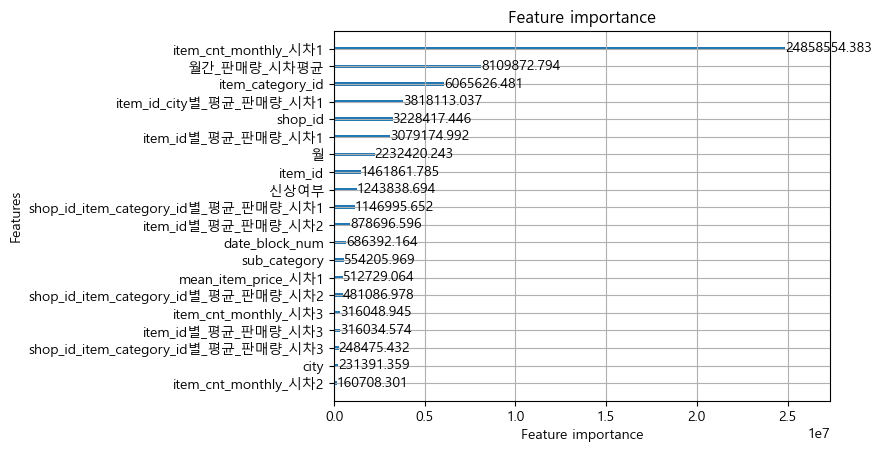

In [254]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.show()

In [255]:
import pandas as pd

# 중요도 추출
importance = lgb_model.feature_importance(importance_type='gain')
feature_names = lgb_model.feature_name()

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# 상위 10개 출력
top_10_features = importance_df.head(10)
top_10_list = top_10_features['feature'].tolist()
print(top_10_list)
# print(top_10_features)

['item_cnt_monthly_시차1', '월간_판매량_시차평균', 'item_category_id', 'item_id_city별_평균_판매량_시차1', 'shop_id', 'item_id별_평균_판매량_시차1', '월', 'item_id', '신상여부', 'shop_id_item_category_id별_평균_판매량_시차1']


In [256]:
import pandas as pd

# 중요도 추출
importance = lgb_model.feature_importance(importance_type='gain')
feature_names = lgb_model.feature_name()

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=True)

# 중요도가 낮은 하위 10개 피처 선택
bottom_10_features = importance_df.head(10)

# 하위 10개 피처 리스트
bottom_10_list = bottom_10_features['feature'].tolist()
print(bottom_10_list)

['item_id_city별_평균_판매량_시차2', 'mean_item_price_시차3', '시차변화량1', 'item_id_city별_평균_판매량_시차3', '시차변화량2', 'mean_item_price_시차2', 'item_cnt_monthly_시차2', 'city', 'shop_id_item_category_id별_평균_판매량_시차3', 'item_id별_평균_판매량_시차3']


In [257]:
print("사용된 피처 수:", len(X_train.columns))
print("사용된 피처 목록:", X_train.columns.tolist())

사용된 피처 수: 26
사용된 피처 목록: ['date_block_num', 'shop_id', 'item_id', 'city', 'item_category_id', 'item_cnt_monthly_시차1', 'item_cnt_monthly_시차2', 'item_cnt_monthly_시차3', 'mean_item_price_시차1', 'mean_item_price_시차2', 'mean_item_price_시차3', 'item_id별 평균 판매량_시차1', 'item_id별 평균 판매량_시차2', 'item_id별 평균 판매량_시차3', 'item_id city별 평균 판매량_시차1', 'item_id city별 평균 판매량_시차2', 'item_id city별 평균 판매량_시차3', 'shop_id item_category_id별 평균 판매량_시차1', 'shop_id item_category_id별 평균 판매량_시차2', 'shop_id item_category_id별 평균 판매량_시차3', '월간 판매량 시차평균', '시차변화량1', '시차변화량2', 'sub_category', '신상여부', '월']


In [258]:
print("Best iteration:", lgb_model.best_iteration)
print("Best RMSE on validation set:", lgb_model.best_score['valid_1']['rmse'])
# 코드 삭제해서 아마 값이 다르게 나올 수 있을 듯
# 0.96774

Best iteration: 378
Best RMSE on validation set: 0.8946919624765457


In [259]:
# import sys
# !{sys.executable} -m pip install optuna

In [260]:
# import optuna
# import lightgbm as lgb
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # 범주형 변수 리스트
# cat_features = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']

# # 범주형 변수 타입 변환
# for col in cat_features:
#     X_train[col] = X_train[col].astype('category')
#     X_valid[col] = X_valid[col].astype('category')

# dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
# dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

# def objective(trial):
#     param = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'seed': 10,
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'force_col_wise': True,
#         'early_stopping_rounds':150,
#     }
    
#     gbm = lgb.train(param,
#                     dtrain,
#                     valid_sets=[dvalid],
#                     num_boost_round=1500,
#     )
    
#     preds = gbm.predict(X_valid)
#     mse = mean_squared_error(y_valid, preds)
#     rmse = np.sqrt(mse)
    
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # 튜닝 반복횟수 설정

In [261]:
# print("Best RMSE:", study.best_value)
# print("Best params:", study.best_params)

In [262]:
X_train_base = X_train.copy()
X_valid_base = X_valid.copy()

In [263]:
# low_importance_features = [
#     'city','item_cnt_monthly_시차3',
#     'item_cnt_monthly_시차2','shop_id item_category_id별 평균 판매량_시차3',
#     'item_id별 평균 판매량_시차3'
# ]
# RMSE: 0.89

In [264]:
# low_importance_features = [
#     'item_id city별 평균 판매량_시차2','시차변화량1',
#     'item_id city별 평균 판매량_시차3', '시차변화량2', 'mean_item_price_시차2'
# ]
# RMSE: 0.89

In [265]:
low_importance_features = [
    'item_id', '시차변화량1', '시차변화량2',
    'mean_item_price_시차3', 'item_id city별 평균 판매량_시차2'
]

In [266]:
# X_train.columns

In [267]:
X_train = X_train_base.drop(columns=low_importance_features)
X_valid = X_valid_base.drop(columns=low_importance_features)

# 3. 범주형 피처 처리
cat_feature_candidates = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']
cat_features = [col for col in cat_feature_candidates if col in X_train.columns]

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [ ]:
# import lightgbm as lgb
# from sklearn.metrics import mean_squared_error

# best_params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'random_state': 42,
#     'force_col_wise': True,
#     'verbosity': -1,
#     'boosting_type': 'gbdt',
#     'num_leaves': 64,
#     'learning_rate': 0.07,
#     'feature_fraction': 0.85,
#     'bagging_fraction': 0.9,
#     'bagging_freq': 5,
#     'min_data_in_leaf': 20,
#     'early_stopping_rounds':50,
#     'verbose_eval':100
# }

# final_model = lgb.train(
#     best_params,
#     train_set=lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features),
#     valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
#     num_boost_round=1500,
# )

# # 3. 예측 및 평가
# final_preds = final_model.predict(X_test)
# mse = mean_squared_error(y_valid, final_preds)
# rmse = np.sqrt(mse)
# print("최종 Validation RMSE:", rmse)


In [272]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'force_col_wise': True,
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.07,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'early_stopping_rounds':50,
    'verbose_eval':100
}

final_model = lgb.train(
    best_params,
    train_set=lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
    num_boost_round=1000,
)

In [273]:
val_preds = final_model.predict(X_valid, num_iteration=final_model.best_iteration)
val_rmse = np.sqrt(mean_squared_error(y_valid, val_preds))

print("Best iteration:", final_model.best_iteration)
print("Best RMSE on validation set:", val_rmse)

Best iteration: 430
Best RMSE on validation set: 0.879796799960729


In [292]:
X_test = X_test.drop(columns=low_importance_features)

In [293]:
# print(X_test.columns.tolist())

In [294]:
# X_test.columns

In [295]:
# X_train.columns

In [296]:
test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)

In [297]:
test_preds

array([0.48296188, 0.75362776, 0.46019681, ..., 0.04362219, 0.0108101 ,
       0.05070999])

In [301]:
data = X_test.copy()

In [302]:
data['predicted_sales'] = test_preds

In [307]:
data

,date_block_num,shop_id,city,item_category_id,item_cnt_monthly_시차1,item_cnt_monthly_시차2,item_cnt_monthly_시차3,mean_item_price_시차1,mean_item_price_시차2,item_id별 평균 판매량_시차1,item_id별 평균 판매량_시차2,item_id별 평균 판매량_시차3,item_id city별 평균 판매량_시차1,item_id city별 평균 판매량_시차3,shop_id item_category_id별 평균 판매량_시차1,shop_id item_category_id별 평균 판매량_시차2,shop_id item_category_id별 평균 판매량_시차3,월간 판매량 시차평균,sub_category,신상여부,월,predicted_sales
9790916,34,5,24,19,0,1,3,0.0,749.500000,0.568182,2.581395,2.833333,0.0,3.0,0.520548,0.696203,0.830303,1.333333,6,0,10,0.482962
9790917,34,5,24,19,1,3,1,1199.0,999.000000,0.954545,1.860465,3.571429,1.0,1.0,0.520548,0.696203,0.830303,1.666667,6,0,10,0.753628
9790918,34,5,24,23,0,0,1,0.0,0.000000,0.659091,1.116279,1.547619,0.0,1.0,0.374150,0.443662,0.487179,0.333333,6,0,10,0.460197
9790919,34,5,24,23,1,1,0,1499.0,749.500000,0.659091,2.162791,2.571429,1.0,0.0,0.374150,0.443662,0.487179,0.666667,6,0,10,0.529660
9790920,34,5,24,20,2,3,0,3999.0,3832.333333,1.431818,5.837209,0.000000,2.0,0.0,0.796460,0.848214,0.000000,1.666667,6,0,10,0.625218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989865,34,45,17,55,1,0,0,99.0,0.000000,0.045455,0.023256,0.071429,0.5,0.0,0.126866,0.074534,0.106061,0.333333,9,0,10,0.101303
9989866,34,45,17,64,0,0,0,0.0,0.000000,0.022727,0.069767,0.000000,0.0,0.0,0.094488,0.117117,0.000000,0.000000,8,0,10,0.016396
9989867,34,45,17,55,0,0,0,0.0,0.000000,0.113636,0.069767,0.095238,0.0,0.0,0.126866,0.074534,0.106061,0.000000,9,0,10,0.043622
9989868,34,45,17,40,0,0,0,0.0,0.000000,0.045455,0.069767,0.166667,0.0,0.0,0.083756,0.074074,0.111645,0.000000,4,0,10,0.010810


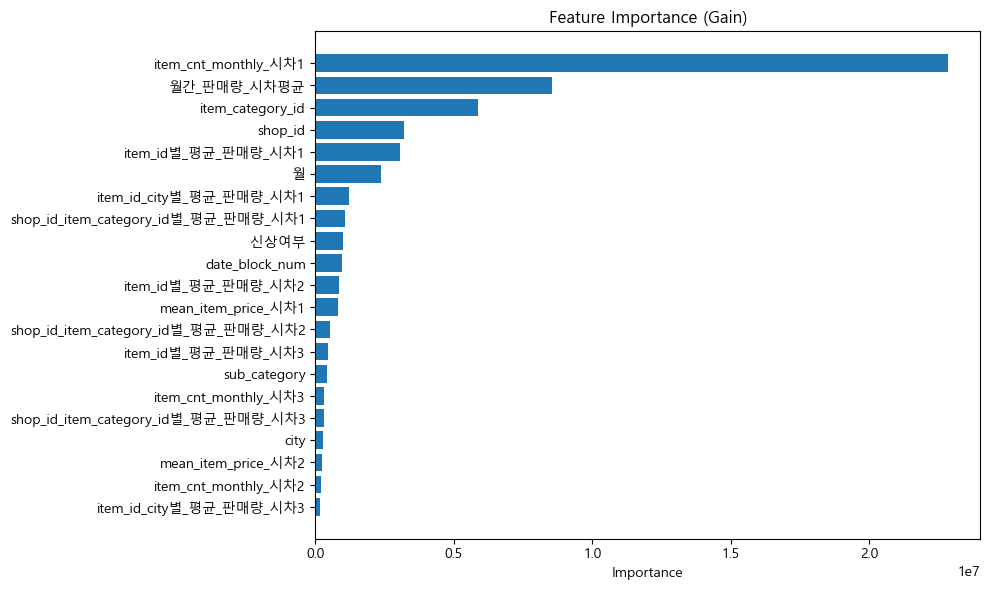

In [298]:
# Feature Importance 시각화
import matplotlib.pyplot as plt
import pandas as pd

importance_df = pd.DataFrame({
    'feature': final_model.feature_name(),
    'importance': final_model.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [306]:
data.to_excel(
    excel_writer = '.\predict_sales_34.xlsx',
    sheet_name = 'Sheet1',
    index = False,       # 0부터 시작하는 자연수 인덱스는 의미가 없음.
    # columns = ['col1, 'col2', 'col3'],
    # encoding = 'utf-8',
    na_rep = '',      # 결측값을 ''으로 채우기
    inf_rep = ''     # 무한값을 ''으로 채우기
)     # 해당 파일이 열려있으면 안됨.